In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import uncertainties as unc
import scipy.optimize as op

In [2]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib notebook

In [3]:
dt = 80.955*10**(-12)

def coincidences(df,t_max,step_tolerance=1,time_tolerance=50,bias=0):
    delays = []
    N1 = 0
    N4 = 0
    t0 = df['t'][0]
    for i in range(len(df)):
        if df['t'][i] - t0 > t_max:
            break
        if df['ch'][i] == 3:
            N4 += 1
            continue
        N1 += 1
        dt_min = time_tolerance + 1
        for j in range(max(0,i-step_tolerance),min(len(df),i+step_tolerance+1)):
            if df['ch'][j] == 1:
                continue
            dt_j = df['t'][j] - df['t'][i] - bias
            if np.abs(dt_j) < np.abs(dt_min):
                dt_min = dt_j
        
        if dt_min != time_tolerance + 1:
            delays.append(dt_min + bias)
        
    return np.array(delays), N1, N4
                
def gaus(x,A,mu,sigma):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

@np.vectorize
def poissonize(r):
    return unc.ufloat(r,np.sqrt(r))

In [16]:
def binary_update(vec):
    for i in range(len(vec)):
        if vec[len(vec) - 1 - i] == 0:
            vec[len(vec) - 1 - i] = 1
            break
        else:
            vec[len(vec) - 1 - i] = 0
    return vec

vec = [0,0,0,0]
keys = []
df_list = []
for i in tqdm(range(16)):
    key = 'x%da%d_y%db%d' %tuple(vec)
    keys.append(key)
    df_list.append(pd.read_csv('data/Bell_test/%s.txt' %key,sep=';',skiprows=5,names=['t','ch']))
    vec = binary_update(vec)

ts = [np.array(df['t'])[-1] - df['t'][0] for df in df_list]
t_max = np.min(ts)
print(t_max*dt)
print(keys)

100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


7.837673653505429
['x0a0_y0b0', 'x0a0_y0b1', 'x0a0_y1b0', 'x0a0_y1b1', 'x0a1_y0b0', 'x0a1_y0b1', 'x0a1_y1b0', 'x0a1_y1b1', 'x1a0_y0b0', 'x1a0_y0b1', 'x1a0_y1b0', 'x1a0_y1b1', 'x1a1_y0b0', 'x1a1_y0b1', 'x1a1_y1b0', 'x1a1_y1b1']


In [49]:
results2 = pd.DataFrame(data=[],columns=['key','N1','N3','mu','sigma','N_coinc'])
results5 = pd.DataFrame(data=[],columns=['key','N1','N3','mu','sigma','N_coinc'])

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


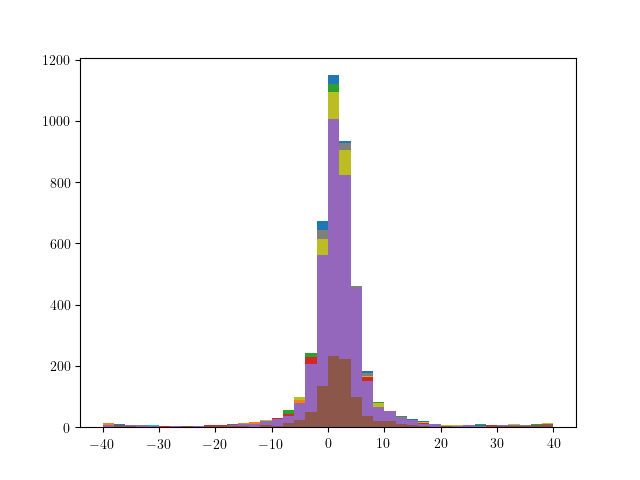

16it [08:15, 30.59s/it]


In [52]:
time_tolerance = 40
coinc_thr = 5

for index,key in tqdm(enumerate(keys)):
    delays,N1,N4 = coincidences(df_list[index],t_max,step_tolerance=1,time_tolerance=time_tolerance)
    ys,edges,pattume = plt.hist(delays,bins=np.arange(-time_tolerance,time_tolerance+1,2))
    xs = 0.5*(edges[:-1] + edges[1:])
    popt,pcov = op.curve_fit(gaus, xs, ys,p0=[len(delays),0,10])
    A,mu,sigma = popt
    
    N_coinc = len([t for t in delays if np.abs(t-mu) < coinc_thr*sigma])
    if coinc_thr == 2:
        results2.loc[index] = [key, N1, N4, mu, sigma, N_coinc]
    elif coinc_thr == 5:
        results5.loc[index] = [key, N1, N4, mu, sigma, N_coinc]

In [51]:
results2

,key,N1,N3,mu,sigma,N_coinc
0,x0a0_y0b0,460211,332669,1.556973,2.636288,3464
1,x0a0_y0b1,491513,315043,1.551728,2.723119,587
2,x0a0_y1b0,461373,334937,1.583436,2.601861,3296
3,x0a0_y1b1,462461,310514,1.504464,2.825052,475
4,x0a1_y0b0,458425,331601,1.729945,2.761490,709
5,x0a1_y0b1,478066,314358,1.611690,2.667797,2850
6,x0a1_y1b0,478207,334818,1.381747,2.818865,383
7,x0a1_y1b1,443065,309826,1.640029,2.714568,3363
8,x1a0_y0b0,461897,332333,1.600093,2.627108,3289
9,x1a0_y0b1,462466,315801,1.634574,2.764414,600


In [40]:
results2.to_csv('results/Bell-coinc2sigma.csv',index=False)
results5.to_csv('results/Bell-coinc5sigma.csv',index=False)

In [4]:
results2 = pd.read_csv('results/Bell-coinc2sigma.csv')

In [6]:
for N in results2['N_coinc']:
    print(poissonize(N))

(3.46+/-0.06)e+03
587+/-24
(3.30+/-0.06)e+03
475+/-22
709+/-27
(2.85+/-0.05)e+03
383+/-20
(3.36+/-0.06)e+03
(3.29+/-0.06)e+03
600+/-24
982+/-31
(2.83+/-0.05)e+03
758+/-28
(2.96+/-0.05)e+03
(3.11+/-0.06)e+03


## Computing CHSH

In [62]:
def access(df,key):
    for i,k in enumerate(df['key']):
        if k == key:
            return df['N_coinc'][i]
    raise KeyError('Invalid key')
    
def E(df,x,y):
    ab = [[0,0],[0,1],[1,0],[1,1]]
    coeff = np.array([1,-1,-1,1])
    ps = []
    for i,c in enumerate(coeff):
        a,b = ab[i]
        key = 'x%da%d_y%db%d' %(x,a,y,b)
        ps.append(poissonize(access(df,key)))
        
    ps = np.array(ps)
    E = np.sum(ps*coeff)
    s = np.sum(ps)
    return E/s

In [63]:
df = results2

E00 = E(df,0,0)
E01 = E(df,0,1)
E10 = E(df,1,0)
E11 = E(df,1,1)

CHSH = E00 + E01 + E10 - E11

print(E00,E01,E10,E11)
print(CHSH)

0.659+/-0.009 0.772+/-0.007 0.643+/-0.009 -0.552+/-0.010
2.626+/-0.017


In [64]:
df = results5

E00 = E(df,0,0)
E01 = E(df,0,1)
E10 = E(df,1,0)
E11 = E(df,1,1)

CHSH = E00 + E01 + E10 - E11

print(E00,E01,E10,E11)
print(CHSH)

0.650+/-0.008 0.764+/-0.007 0.638+/-0.008 -0.541+/-0.009
2.593+/-0.016
